# Projecting Reviews about the Host per Listing, per Year Based on the Topics

In [23]:

# import and setup modules we'll be using in this notebook
import logging
import seaborn as sns
import itertools
import pandas as pd
import numpy as np
import gensim
import sys
reload(sys)
import cPickle
import re
sys.setdefaultencoding('utf8')
logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore
import matplotlib.pylab as plt
import matplotlib.ticker as mtick
%matplotlib inline

In [8]:
model = gensim.models.LdaModel.load('lda.pkl')
#top_topics = model.top_topics(corpus, num_words=5)
top_topics=model.show_topics()

[(0,
  u'0.180*"family" + 0.121*"husband" + 0.037*"son" + 0.029*"mother" + 0.026*"mom" + 0.023*"brooklyn" + 0.022*"daughter" + 0.020*"park" + 0.017*"hidden" + 0.017*"house"'),
 (1,
  u'0.236*"new" + 0.195*"york" + 0.194*"new_york" + 0.077*"nyc" + 0.030*"village" + 0.029*"east" + 0.017*"west" + 0.013*"east_village" + 0.011*"upper" + 0.009*"west_village"'),
 (2,
  u'0.061*"restaurant" + 0.033*"recommendation" + 0.033*"area" + 0.027*"local" + 0.026*"neighborhood" + 0.025*"bar" + 0.019*"shop" + 0.018*"brooklyn" + 0.018*"eat" + 0.017*"nearby"'),
 (3,
  u'0.026*"arrived" + 0.019*"late" + 0.017*"day" + 0.015*"arrival" + 0.013*"met" + 0.012*"night" + 0.012*"let" + 0.011*"left" + 0.010*"provided" + 0.010*"got"'),
 (4,
  u'0.048*"easy" + 0.035*"question" + 0.033*"check" + 0.032*"helpful" + 0.032*"responsive" + 0.024*"accommodating" + 0.022*"communication" + 0.017*"quick" + 0.017*"key" + 0.015*"available"'),
 (5,
  u'0.150*"room" + 0.092*"nice" + 0.048*"roommate" + 0.044*"guy" + 0.043*"meet" + 0.

# Reading in vectorized corpus

In [10]:
with open(r"corpus.pickle", "rb") as input_file:
    corpus= cPickle.load(input_file)

In [11]:
topics=[]
top_topics=model.show_topics()
for t in top_topics:
    topic={}
    for chunk in t[1].split('+'):
        topic[chunk.split('*')[1].strip("'")] = float(chunk.split('*')[0])
    topics.append(topic)
    
from pprint import pprint
#pprint(top_topics)
df_list=[]

for topic in topics:

    df_= pd.DataFrame([(str(k),v) for k,v in topic.iteritems() ])
    df_.sort_values([1], ascending=False)
    
    df_list.append( df_[0])

df = pd.concat(df_list, axis = 1)
df.columns=[ [ 'Topic'+str(i) for i in range(len(df_list))]]


In [16]:
df_text=pd.read_csv('../DataFiles/sentences_withPersonName_NYC_listing.csv')
df_text=df_text[df_text.year>2009]
df_=pd.DataFrame(df_text.groupby(['listing_id']).year.count())
indices=df_[df_.year==7].index.tolist()
df_text=df_text[df_text['listing_id'].isin(indices)]

In [ ]:

num_topics= model.num_topics
for i in range(num_topics):
    df_text['topic'+str(i)]=0.0

for i in range(len(corpus)):
    topic_dist=model.get_document_topics(corpus[i])
    if i % 1000 ==0:print i,'/',len(corpus)

    for j in range(len(topic_dist)):
        topic_no=topic_dist[j][0]
        
        df_text.set_value(i,'topic'+str(j) , topic_dist[j][1])
        
df_text.to_csv('../DataFiles/sentences_withPersonName_NYC_listing_topics.csv')       

In [18]:
topic_dist
['year']+ ['topic'+str(i) for i in range(10)]

['year',
 'topic0',
 'topic1',
 'topic2',
 'topic3',
 'topic4',
 'topic5',
 'topic6',
 'topic7',
 'topic8',
 'topic9']

In [19]:
df_year=df_text[['year']+ ['topic'+str(i) for i in range(10)]]
df_year=df_year.groupby('year').mean()
df_year.to_csv('../DataFiles/topicOverTimeNYC.csv')

# Chanages of contribution to each topic over time

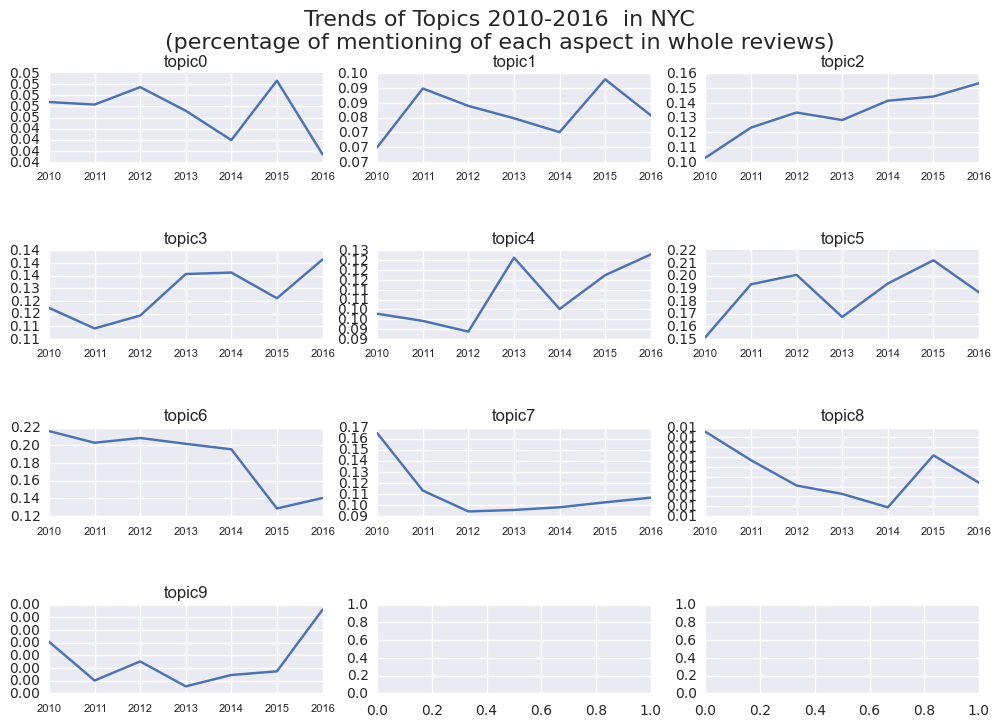

In [24]:
df_year=pd.read_csv('../DataFiles/topicOverTimeNYC.csv')
 
params = {'legend.fontsize': 8,}
plt.rcParams['figure.figsize'] = 12,8
f, axarr = plt.subplots(4,3)
plt.subplots_adjust(hspace=1)

plt.suptitle('Trends of Topics 2010-2016  in NYC\
             \n(percentage of mentioning of each aspect in whole reviews)',fontsize=16)
k=0
x=range(2010,2017)
for i in range(0,4):
    for j in range(0,3):

        sns.set_style("darkgrid")
        if k>9: break
        plt.rcParams.update(params)
        y=df_year['topic'+str(k)]

        axarr[i, j].plot(x, y)
        axarr[i, j].set_title('topic'+str(k))
      #  axarr[i, j].set_ylim(0,1)
        axarr[i, j].get_xaxis().get_major_formatter().set_useOffset(False)
        axarr[i, j].yaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f'))
        for tick in axarr[i, j].get_xaxis().get_major_ticks():

            tick.label.set_fontsize(8) 
#            tick.label.set_rotation('vertical')

        k+=1